# Hyperparameter Tuning Coding Challenge

## Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hinge_loss
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


## Spirals

### Dataset Construction
Below we create a toy dataset consisting of 'spiral clusters' of datapoints. This dataset is visualised below.

In [3]:
num_classes = 2    # The number of classes (distinct groups) of data (these are our "y" values)
dimensions = 2    # The number of dimensions of our input or "X" values
points_per_class = 100    # number of X points to generate for each of the y values
box_limits = 100

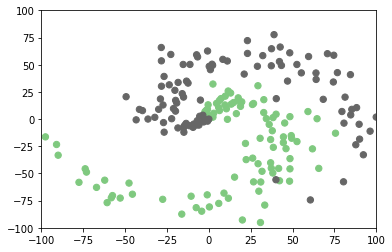

In [4]:
def generate_spiral_data(num_classes, dimensions, points_per_class):
    # First we set a random seed, this allows us to get the exact same data each time we run the cell.
    np.random.seed(2)
    """Generate `num_classes` spirals with `points_per_class` points per spiral."""
    
    X = np.zeros((points_per_class*num_classes, dimensions), dtype='float32')    # Create an empty matrix to hold our X values
    y = np.zeros(points_per_class*num_classes, dtype='float32')    # Create an empty vector to hold our y values

    for y_value in range(num_classes):     # Generate data for each class
        ix = range(points_per_class*y_value, points_per_class*(y_value+1))    # The indices in X and y where we will save this class of data

        radius = np.linspace(0.0, box_limits, points_per_class)    # Generate evenly spaced numbers in the interval 0 to box_limits
        theta = np.linspace(y_value*4, (y_value+1)*4, points_per_class) + np.random.randn(points_per_class) * 0.5   

        X[ix] = np.column_stack([radius*np.sin(theta), radius*np.cos(theta)])     # Convert polar coordinates to standard Euclidian coordinates
        y[ix] = y_value
    
    y[y==0] = -1
    return X, y
        
def plot_data(X, y):
    """Use Matplotlib to plot X, y data on a figure."""
    fig = plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Accent)
    plt.xlim([-box_limits,box_limits])
    plt.ylim([-box_limits,box_limits])
    return fig

X, y = generate_spiral_data(num_classes, dimensions, points_per_class)

fig = plot_data(X, y)

## Question 1 - Data Processing


Write a function to pre-processing the data so that we can run it through the classifier. The function should:
* Split the data into 80% training and 20% testing data
* Set random_state to equal 42 for this internal method. 

_**Function Specifications:**_
* Should take `X` and `y` as input.
* Should return two `tuples` of the form `(X_train, y_train), (X_test, y_test)`.

In [5]:
def data_preprocess(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return (X_train, y_train), (X_test, y_test)

In [6]:
(X_train, y_train), (X_test, y_test) = data_preprocess(X,y)
print(X_train[:2]);
print(y_train[:2]);
print(X_test[:2]);
print(y_test[:2]);

[[ 65.6617   -45.345993]
 [ 92.312195 -32.84051 ]]
[-1.  1.]
[[-90.02301  -33.228016]
 [  4.592955  14.438601]]
[-1. -1.]


_**Expected Outputs:**_

```python
(X_train, y_train), (X_test, y_test) = data_preprocess(df)
print(X_train[:2])
print(y_train[:2])
print(X_test[:2])
print(y_test[:2])
```
```
[[ 65.6617   -45.345993]
 [ 92.312195 -32.84051 ]]
[-1.  1.]
[[-90.02301  -33.228016]
 [  4.592955  14.438601]]
[-1. -1.]


```

## Question 2 - Model Training

Now that you have processed your data, let's jump straight into model fitting. Write a function that should:
* Instantiate a `SVC` model.
* Train the `SVC` model with default parameters.
* Return the trained SVC model. 

_**Function Specifications:**_
* Should take two numpy `arrays` as input in the form `(X_train, y_train)`.
* Should return an sklearn `SVC` model which has a random state of 0.
* The returned model should be fitted to the data.

In [7]:
def train_SVC_model(X_train,y_train):
    svc = SVC(random_state=0)
    return svc.fit(X_train, y_train)

In [8]:
svc = train_SVC_model(X_train,y_train)
svc.classes_

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([-1.,  1.], dtype=float32)


_**Expected Outputs:**_

```python
svc.classes_
```
```
array([-1.,  1.], dtype=float32)
```

## Question 3 - Model Testing

Now that you've trained your model. It's time to test its accuracy, however, we'll be using a custom scoring function for this. Create a function that implements the hinge loss function:

$$
\large \mathcal{L}(Y,\hat{Y})= \frac{1}{N}\sum_{i=1}^{N}max(0,1-y_{i} . \hat{y}_{i})
$$

_**Function Specifications:**_
* Should take two numpy `arrays` as input in the form `y_true` and `y_predicted`.
* Should return a `float` for the hinge loss value.

In [27]:
def custom_scoring_function(y_true, y_predicted):
    hinge_loss_score = float(hinge_loss(y_true, y_predicted))
    return hinge_loss_score

In [28]:
# test model
y_pred = svc.predict(X_test)
print('Hinge Loss value: ',custom_scoring_function(y_test,y_pred))
print('Accuracy: ',accuracy_score(y_test,y_pred))

Hinge Loss value:  0.9
Accuracy:  0.55


_**Expected Outputs:**_
```python
print('Hinge Loss value: ',custom_scoring_function(y_test,y_pred))
print('Accuracy: ',accuracy_score(y_test,y_pred))
```

> ```
Hinge Loss value:  0.9
Accuracy:  0.55
```

## Hyperparameter Optimization

### Question 4.1 - Getting model parameters
In order to improve the accuracy of our classifier, we have to search for the best possible model (`SVC` in this case) parameters. However, we first have to find out what parameters can be tuned for the given model. Write a function that returns a list of available hyperparameters for a given model. 

_**Function Specifications:**_
* Should take in an sklearn model (estimator) object.
* Should return a list of parameters for the given model.

In [29]:
def get_model_hyperparams(model):
    return list(model.get_params().keys())

In [30]:
get_model_hyperparams(svc)

['C',
 'cache_size',
 'class_weight',
 'coef0',
 'decision_function_shape',
 'degree',
 'gamma',
 'kernel',
 'max_iter',
 'probability',
 'random_state',
 'shrinking',
 'tol',
 'verbose']

_**Expected Outputs:**_

```python
get_model_hyperparams(SVC)
```

> ```
['C',
 'cache_size',
 'class_weight',
 'coef0',
 .
 .
 .
 'shrinking',
 'tol',
 'verbose']
```

### Question 4.2 - Hyperparameter Search
The next step is define a set of `SVC` hyperparameters to search over. Write a function that searches for optimal parameters over the following set of hyperparameters:

- C_list = [0.001, 1, 10]
- gamma_list = [0.001, 0.1, 1]

and using `custom_scoring_function` from **Question 3** above as a custom scoring function (_**Hint**_: Have a look at at the `make_scorer` object in sklearn `metrics`).

_**Function Specifications:**_
* Should define a parameter grid using the given list of `SVC` hyperparameters
* Should return a list of parameters for the given model.
* Should return an sklearn `GridSearchVC` object with .

In [34]:
def tune_SVC_model(X_train, y_train):
    
    svc = train_SVC_model(X_train,y_train)
    hinge_loss = make_scorer(custom_scoring_function, greater_is_better=False)
    parameters = {'C':(0.001,1,10),'gamma': (0.001,0.1,1)}
    clf = GridSearchCV(svc, parameters, scoring=hinge_loss)
    return clf.fit(X_train,y_train)

svc_tuned = tune_SVC_model(X_train, y_train)

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [35]:
y_pred = svc_tuned.predict(X_test)
print('Hinge Loss value: ',custom_scoring_function(y_test,y_pred))
print('Accuracy: ',accuracy_score(y_test,y_pred))

Hinge Loss value:  0.05
Accuracy:  0.975


_**Expected Outputs:**_
```python
print('Hinge Loss value: ',custom_scoring_function(y_test,y_pred))
print('Accuracy: ',accuracy_score(y_test,y_pred))
```

> ```
Hinge Loss value:  0.05
Accuracy:  0.975
```

### Question 4.3 - Optimal model parameters
Write a function that returns the best hyperperameters for a given model (i.e. the `GridSearchCV`). 

_**Function Specifications:**_
* Should take in an sklearn GridSearchCV object.
* Should return a dictionary of optimal parameters for the given model.

In [43]:
# function that returns best params
def get_best_params(model):
    return model.best_params_

In [44]:
get_best_params(svc_tuned)

{'C': 1, 'gamma': 0.001}

_**Expected Outputs:**_
```python
get_best_params(svc_tuned)
```

> ```
{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
```